In [159]:
import pandas as pd
import numpy as np
import datatable as dt
from tqdm import tqdm_notebook
import graphviz
from collections import defaultdict
from gplearn.functions import make_function

ACTIONS_WITH_ITEM_REFERENCE = {
    "search for item",
    "interaction item info",
    "interaction item image",
    "interaction item deals",
    "interaction item rating",
    "clickout item",
}

In [143]:
df = pd.read_csv("../../../data/events_sorted.csv", nrows=4000000) 


  6%|▋         | 3618/57257 [00:20<02:05, 429.00it/s]

In [161]:
all_obs = []
for user_id, df_user in tqdm_notebook(df.iloc[:4000000].groupby("user_id"), mininterval=1):
    obs = {}
    events_dict = defaultdict(list)
    events_interaction = []
    max_timestamp = 0
    
    # aggregate to lists
    for row in df_user.to_dict(orient='records'):        
        obs["mobile"] = int(row["device"]=="mobile")
        action_type = row["action_type"].replace(" ", "_")
        events_dict[action_type].append(row)
        if row["action_type"] in ACTIONS_WITH_ITEM_REFERENCE:
            events_interaction.append(row)
        max_timestamp = max(max_timestamp, row["timestamp"])
        
    for action_type in events_dict.keys():
        for event_num, row in enumerate(events_dict[action_type][::-1]):
            if event_num == 0 and action_type == "clickout_item":
                impressions = row["impressions"].split("|")
                prices = row["prices"].split("|")
                obs["item_count"] = len(impressions)
                if row["reference"] in impressions:
                    obs["index_clicked"] = impressions.index(row["reference"])
                        
            if event_num <= 10:
                if action_type == "clickout_item":
                    for rank, (item_id, price) in enumerate(zip(impressions, prices)):
                        price = int(price)
                        item_id = int(item_id)
                        obs[f"co_item_id_{rank:02d}_{event_num:02d}"] = np.log1p(item_id)
                        obs[f"co_price_{rank:02d}_{event_num:02d}"] = np.log1p(price)
                
                obs[f"{action_type}_{event_num:02d}_timestamp"] = np.log1p(max_timestamp - row["timestamp"])
                if row["action_type"] in ACTIONS_WITH_ITEM_REFERENCE and isinstance(row["fake_impressions"], str):
                    impressions = row["fake_impressions"].split("|")
                    if row["reference"] in impressions and not (event_num == 0 and action_type == "clickout_item"):
                        obs[f"{action_type}_rank_{event_num:02d}"] = impressions.index(row["reference"])

    for event_num, row in enumerate(events_interaction[::-1][:10]):
        if isinstance(row["fake_impressions"], str) and not (event_num == 0 and row["action_type"] == "clickout item"):
            impressions = row["fake_impressions"].split("|")
            if row["reference"] in impressions:
                obs[f"all_events_interaction_rank_{event_num:02d}"] = impressions.index(row["reference"])
            
    if "index_clicked" in obs:
        all_obs.append(obs)

In [162]:
df_all = pd.DataFrame.from_records(all_obs)

In [163]:
# price_cols = [col for col in df_all.columns if col.startswith("price_")]
# item_id_cols = [col for col in df_all.columns if col.startswith("item_id_impressions_clickout_item")]
cols = [col for col in df_all.columns if col not in ("user_id", "index_clicked")]
X = df_all[cols].fillna(0)
y = df_all["index_clicked"].values
print(list(X.shape))

[199899, 737]


In [164]:
from gplearn.genetic import SymbolicTransformer, SymbolicRegressor, SymbolicClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

est = make_pipeline(
        make_union(
            SymbolicTransformer(parsimony_coefficient=.001,
                                random_state=1,
                                function_set=['add', 'sub', 'mul', 'div', 'min', 'max', 'sqrt', 'log', 'abs', 'neg', 'inv'],
                                verbose=True),
        ),
        LGBMClassifier(n_estimators=20)
)

est = LGBMClassifier(n_estimators=40, importance_type="gain")
# est = MLPClassifier(hidden_layer_sizes=(50,), max_iter=50, verbose=True)
X_tr, X_va, y_tr, y_va = train_test_split(X, y)
est.fit(X_tr, y_tr)

va_pred = est.predict(X_va)
print((va_pred == y_va).mean())

tr_pred = est.predict(X_tr)
print((tr_pred == y_tr).mean())

0.5426913456728364
0.5662669085670072


In [165]:
va_pred_proba = est.predict_proba(X_va)
va_pred_proba

array([[0.05190937, 0.02402776, 0.79504767, ..., 0.00184511, 0.00333597,
        0.00270187],
       [0.82947352, 0.02947866, 0.0287723 , ..., 0.00214561, 0.00198034,
        0.00224266],
       [0.11516749, 0.04220079, 0.0450953 , ..., 0.00687181, 0.00615451,
        0.07396847],
       ...,
       [0.66358886, 0.07201488, 0.03254605, ..., 0.00655729, 0.00459304,
        0.00395964],
       [0.72759058, 0.04973176, 0.02845685, ..., 0.00326775, 0.00351258,
        0.00104598],
       [0.03633606, 0.01308934, 0.00959267, ..., 0.00230473, 0.00188492,
        0.00308764]])

In [166]:
mrr = (1/(np.argsort(-va_pred_proba, axis=1)[np.arange(va_pred_proba.shape[0]), y_va]+1)).mean()
mrr

0.523141460787876

In [157]:
(1==(np.argsort(-va_pred_proba, axis=1)[np.arange(va_pred_proba.shape[0]), y_va]+1)).mean()

0.39639819909954976

In [171]:
def _logical(x1, x2, x3, x4):
    return np.where(x1 > x2, x3, x4)

logical = make_function(function=_logical,
                        name='logical',
                        arity=4)

def _eq(x1, x2):
    return np.where(x1 == x2, 1, 0)

eq = make_function(function=_eq,
                        name='eq',
                        arity=2)


est = SymbolicRegressor(parsimony_coefficient=.002,
                  random_state=1,
                  population_size=10000,
                  function_set=['add', 'sub', 'mul', 'div', 'min', 'max', logical, eq], #, 'sqrt', 'log', 'abs', 'neg', 'inv'],
                  feature_names=X.columns,
                  n_jobs=1,
                  verbose=True)
X_tr, X_va, y_tr, y_va = train_test_split(X, y)
est.fit(X_tr, y_tr)

va_pred = est.predict(X_va)
print((va_pred == y_va).mean())

tr_pred = est.predict(X_tr)
print((tr_pred == y_tr).mean())

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    42.76          136.362        3          3.17486              N/A     78.68m
   1     5.84          4.52294        9          3.16874              N/A     23.91m
   2     4.91          4.08693        5          3.14682              N/A     10.96m
   3     3.06          3.43427        5          3.12359              N/A      7.39m
   4     1.70          3.23075        5          3.12359              N/A      4.59m
   5     4.17          3.39262        7          3.10731              N/A      6.84m
   6     5.47          3.54689       11          3.08584              N/A      6.73m
   7     6.38          3.61232       19          3.07173              N/A      6.26m
   8     8.70          3.61291       23          3.06861              N/A  

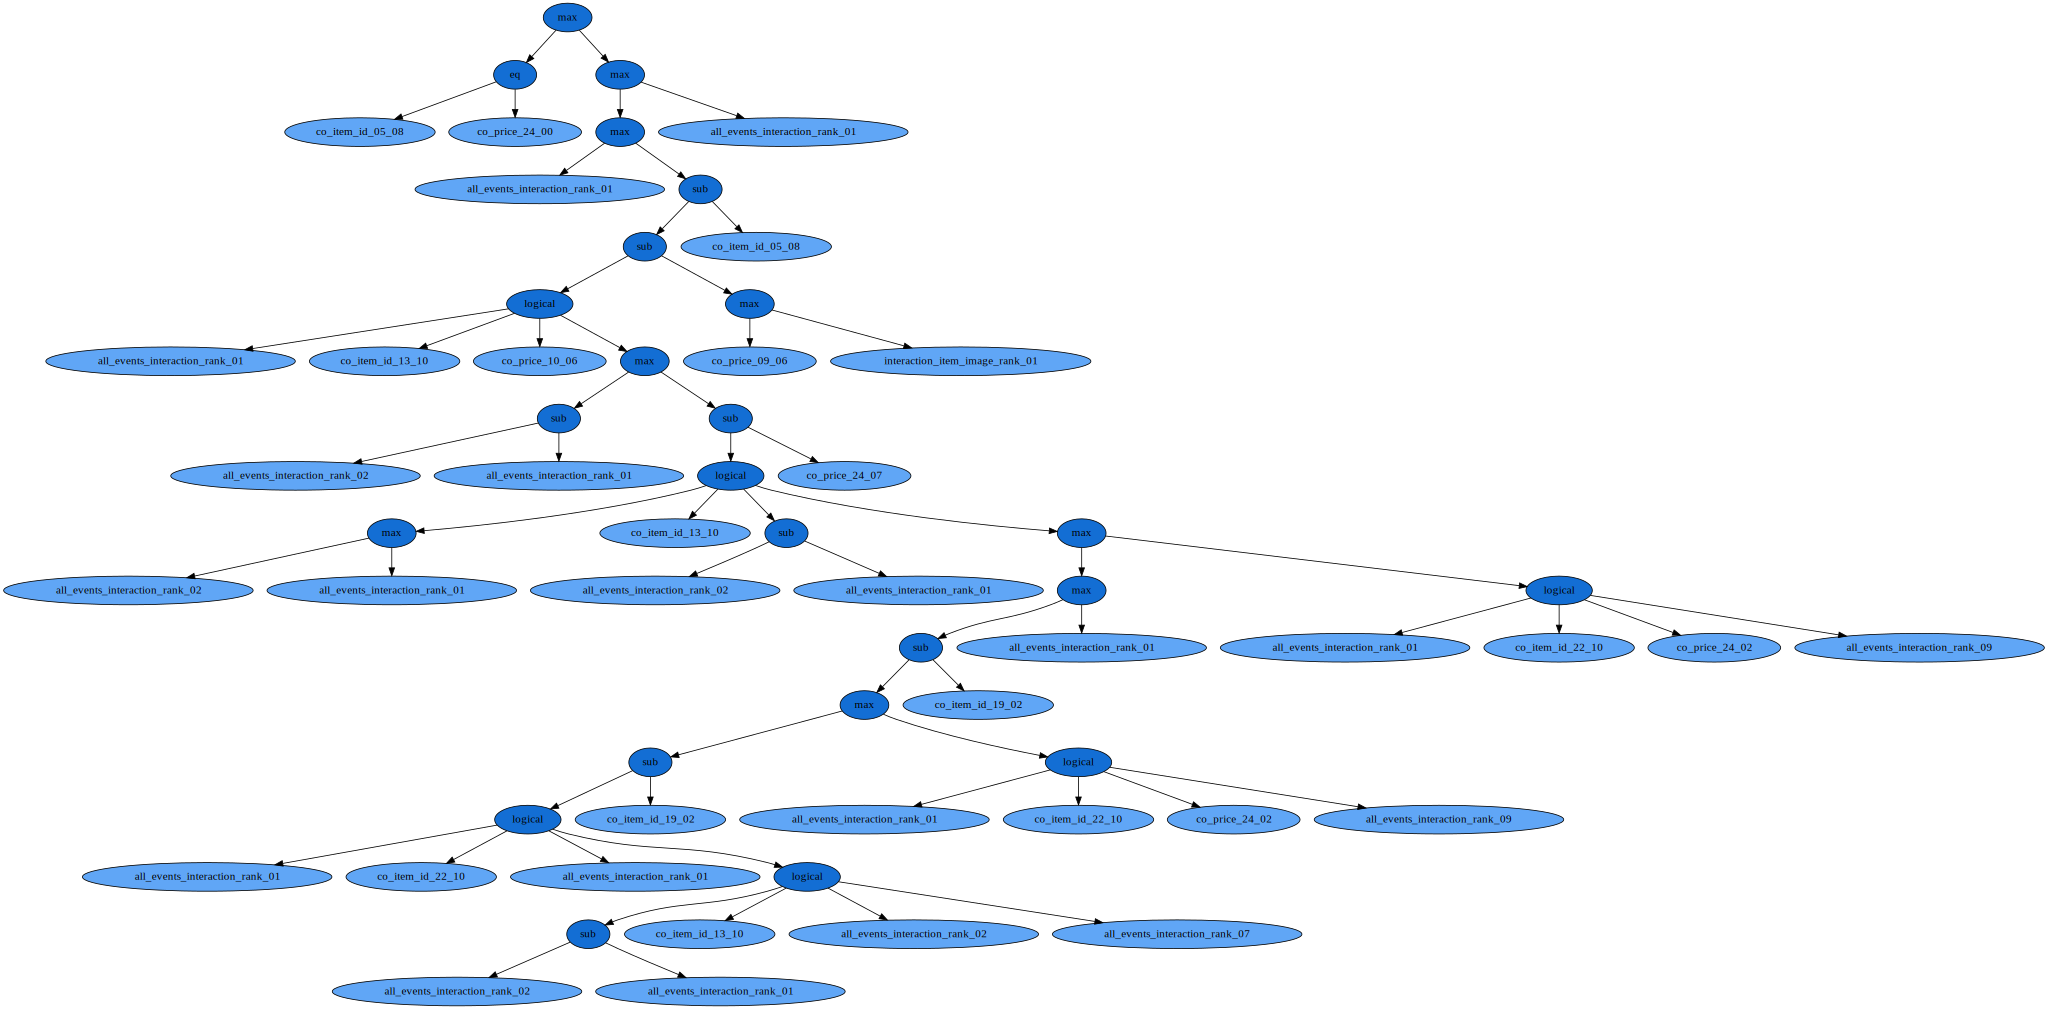

In [170]:
dot_data = est._program.export_graphviz()
# dot_data = [p for p in est.steps[0][1].transformer_list[0][1]._programs[0] if p][6].export_graphviz()
graph = graphviz.Source(dot_data)
graph

In [169]:
fimp = list(zip(X.columns, est.feature_importances_))
df_imp = pd.DataFrame.from_records(fimp, columns=["col", "imp"])
df_imp.sort_values("imp", ascending=False)

AttributeError: 'SymbolicRegressor' object has no attribute 'feature_importances_'

In [114]:
np.log1p(X.max().max())

16.2358652643024

In [80]:
for user_id in ["FQRBCER0ZLL2"
"Q96SCXXTDFIY",
"16P4IKHQOFH9",
"9IX5ZDR4ILCT",
"SDIJIN0AB10V",
"9E2B0S64W9Q1",
"WK3LAGIG68D1",
"C68A4O3K23SS",
"4L9AHS5G0FDC",
"6W1AAZIPI05W",
"S5U9A8JTZ3WF",
"6YTGSXN6TGBL",
"29TI7SS2CSQ8"]:
    
    clickouts = df[(df["user_id"]==user_id)&(df["action_type"]=="clickout item")]
    print(clickouts.shape[0], clickouts["reference"].nunique())

0 0
60 52
55 54
55 16
52 52
52 50
48 46
40 11
38 10
38 29
37 28
35 21


In [82]:
clickouts_num = df[df["action_type"]=="clickout item"].groupby("user_id")["session_id"].count().sort_values(ascending=False)
clickouts_num.value_counts()

1     31930
2     10836
3      4679
4      2448
5      1354
6       810
7       506
8       345
9       237
10      134
11      114
12      101
13       66
15       48
14       46
16       29
17       24
19       15
21       13
20       11
18       10
22       10
23       10
24        8
28        4
25        3
30        3
33        2
26        2
52        2
38        2
55        2
31        2
37        1
73        1
35        1
48        1
66        1
34        1
60        1
40        1
Name: session_id, dtype: int64